In [1]:
import numpy as np
from scipy.ndimage.measurements import label, extrema
from scipy.ndimage.measurements import sum as ndSum
from scipy.ndimage.measurements import maximum as ndMax
import pandas as pd
import xarray as xy
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import string
from matplotlib import cm  #colormap
import os.path
from copy import deepcopy
from time import time
from geopy.distance import vincenty

%matplotlib inline

In [2]:
class GeographicBounds(object):
    def __init__(self, lonMin, lonMax, latMin, latMax):
        self.lonMin = lonMin
        self.lonMax = lonMax
        self.latMin = latMin
        self.latMax = latMax

def startMonth(season):
    if season == 'DJF':
        return 12
    elif season == 'MAM':
        return 3
    elif season == 'JJA':
        return 6
    elif season == 'SON':
        return 9
    
#land fraction is the same for all runs on the same mesh:
directory = '/data/public/reanalysis/erai_daily_netcdf/totalColumnWV/'
filename = ''.join([directory,'landSeaMask.nc'])

toGetLandFrac = xy.open_dataset(filename)
bounds = GeographicBounds(190, 250, 25, 65)
toGetLandFrac = toGetLandFrac.sel(longitude=slice(bounds.lonMin,bounds.lonMax),latitude=slice(bounds.latMax,bounds.latMin))
landFracArr = np.asarray(toGetLandFrac['lsm'].squeeze())
#-**-data-set dependent-**---
HALFCELLINDEG = 0.3515625
#----------------------------
def getCellArea(lon,lat):
    y = vincenty((lat-HALFCELLINDEG,0),(lat+HALFCELLINDEG,0)).kilometers
    x = vincenty((lat,lon-HALFCELLINDEG),(lat,lon+HALFCELLINDEG)).kilometers
    return x * y

#can also do this part once, since all the time steps are on the same grid:
latArr = np.asarray(toGetLandFrac.latitude)
lonArr = np.asarray(toGetLandFrac.longitude)
lonArr, latArr = np.meshgrid(lonArr,latArr)
cellAreaArr = deepcopy(lonArr) 
for i in xrange(len(latArr)):
    for j in xrange(len(lonArr)):
        cellAreaArr[i,j] = getCellArea(lonArr[i,j],latArr[i,j])

def getARmask(tmqOne):
    maxArr = np.asarray(tmqOne).squeeze()
    maxArr[np.nonzero(maxArr<THRESHOLD)] = 0 
    labels, numL = label(maxArr) 
    onlyOneLabel = np.zeros(labels.shape)
    if numL > 0:
        sizesOfLabeledRegions = [len(labels[labels==i]) 
                                     for i in range(1, numL + 1)]
        whichLabel = np.argmax(sizesOfLabeledRegions) 
        onlyOneLabel = np.zeros(labels.shape)
        onlyOneLabel[np.nonzero(labels==whichLabel+1)] = 1
    return onlyOneLabel
        
def hasAR(tmqOne):
    ARmask = getARmask(tmqOne)
    if ARmask.any():
        lats = extrema(latArr,ARmask)
        lons = extrema(lonArr,ARmask)
        lowerLeft = (lats[0],lons[0])
        upperRight = (lats[1],lons[1])
        areaSum = ndSum(cellAreaArr,ARmask)
        lengthKM = vincenty(lowerLeft, upperRight).kilometers
        width = areaSum/lengthKM
        
        landFracPoints = extrema(landFracArr,ARmask) 
        if landFracPoints[0] > 0.2 or landFracPoints[1] > 0.2:
            touchesContinent = True
        else:
            touchesContinent = False
            return xy.DataArray([0])
        
        if touchesContinent:    
            maxLandFallLat = np.max(latArr[np.logical_and(landFracArr>0.2,ARmask)])
            minLandFallLat = np.min(latArr[np.logical_and(landFracArr>0.2,ARmask)])
            extentLandfall = vincenty([minLandFallLat,0],[maxLandFallLat,0]).kilometers
                
            if extentLandfall > 1000:
                return xy.DataArray([0])
            maxLandFallLon = np.max(lonArr[np.logical_and(landFracArr>0.2,ARmask)])
            
            if (maxLandFallLat < NorthLat and maxLandFallLat > SouthLat) or \
                (minLandFallLat < NorthLat and minLandFallLat > SouthLat):
                inRegion = True
            
                if(maxLandFallLon > EastLon or maxLandFallLon < WestLon):
                    inRegion = False
            else:
                inRegion = False
        
        if (lengthKM > 2000) and (width < 1000) and touchesContinent and inRegion: 
            return xy.DataArray([1])
        else:
            return xy.DataArray([0])
    else:
        return xy.DataArray([0])
    
def plotAR(ax,tmqToPlot,bounds):
    ax.set_extent((bounds.lonMin, bounds.lonMax, bounds.latMin, bounds.latMax)) 
    contourPart = tmqToPlot.squeeze().plot.contourf(ax=ax, transform=ccrs.PlateCarree(),vmax=THRESHOLD+1) #,colors='c',vmin=2,vmax=2) 
    ax.coastlines()
    ax.gridlines()

In [3]:
regions = dict([('Alaska',GeographicBounds(190,219,55,80)), \
                ('BC',GeographicBounds(219,250,49.5,80)), \
                ('WAandOR',GeographicBounds(219,250,41.5,49.5)), \
                ('WA',GeographicBounds(219,250,45.5,49.5)), \
                ('OR',GeographicBounds(219,250,41.5,45.5)), \
                ('Cali',GeographicBounds(219,250,32.5,41.5)), \
                ('All',GeographicBounds(190,250,34,80))])

regions = dict([('WAandOR',GeographicBounds(219,250,45.5,49.5)), \
                 ('Cali',GeographicBounds(219,250,32.5,41.5))])

In [5]:
directoryData = '/data/public/reanalysis/erai_daily_netcdf/totalColumnWV/'
field = 'tcw'

oneFile = ''.join([directoryData,'ERAI_tcw_1979-2016.nc']) 
THRESHOLD = 2 
bounds = GeographicBounds(190, 250, 25, 65)
for whichRegion in regions:
    t1 = time()

    NorthLat = regions[whichRegion].latMax
    SouthLat = regions[whichRegion].latMin
    EastLon = regions[whichRegion].lonMax
    WestLon = regions[whichRegion].lonMin

    tmq = xy.open_dataset(oneFile)
    tmq = tmq.sel(longitude=slice(bounds.lonMin,bounds.lonMax),latitude=slice(bounds.latMax,bounds.latMin))
    tmq = tmq.resample(time='D').mean() #daily means of six-hourly data
    tmq=tmq[field]/10.0

    events = tmq.groupby('time').apply(hasAR)

    eventsOne = events.to_pandas() 
    eventsOne.index = pd.to_datetime(eventsOne.index)
    eventsOne[eventsOne[0]==1].to_csv('/work/ngoldenson/ARsDetected/daysWithARs'+whichRegion+'DailyMeanERAI.csv')
    allEventsTimeSeries = eventsOne.resample('M').sum()

    allEventsTimeSeries.to_csv(''.join(['/work/ngoldenson/ARsDetected/AReventTimeSeries',whichRegion,'DailyMeanERAI.csv']))

    bySeason = eventsOne['19821201':'20160531'].resample('3MS').sum()
    bySeason.loc[(bySeason.index.month==startMonth('DJF'))].to_csv(''.join(['/work/ngoldenson/ARsDetected/AReventsDJFonly',whichRegion,'DailyMeanERAI.csv'])) 
    bySeason.loc[(bySeason.index.month==startMonth('SON'))].to_csv(''.join(['/work/ngoldenson/ARsDetected/AReventsSONonly',whichRegion,'DailyMeanERAI.csv']))
    bySeason.loc[(bySeason.index.month==startMonth('MAM'))].to_csv(''.join(['/work/ngoldenson/ARsDetected/AReventsMAMonly',whichRegion,'DailyMeanERAI.csv']))
    
    t2 = time()
    print('finding ',whichRegion,' ARs took ', (t2-t1), ' seconds, or ~', (t2-t1)/60.0, ' minutes')

('finding ', 'Cali', ' ARs took ', 56.50079703330994, ' seconds, or ~', 0.9416799505551656, ' minutes')
('finding ', 'WAandOR', ' ARs took ', 55.5495228767395, ' seconds, or ~', 0.9258253812789917, ' minutes')


In [6]:
#reimport tmq so its not masked
tmq = xy.open_dataset(oneFile)
tmq = tmq.sel(longitude=slice(bounds.lonMin,bounds.lonMax),latitude=slice(bounds.latMax,bounds.latMin))
tmq = tmq.resample(time='D').mean()
tmq=tmq[field]/10.0


In [7]:
ARs = eventsOne[eventsOne[0]==1].index

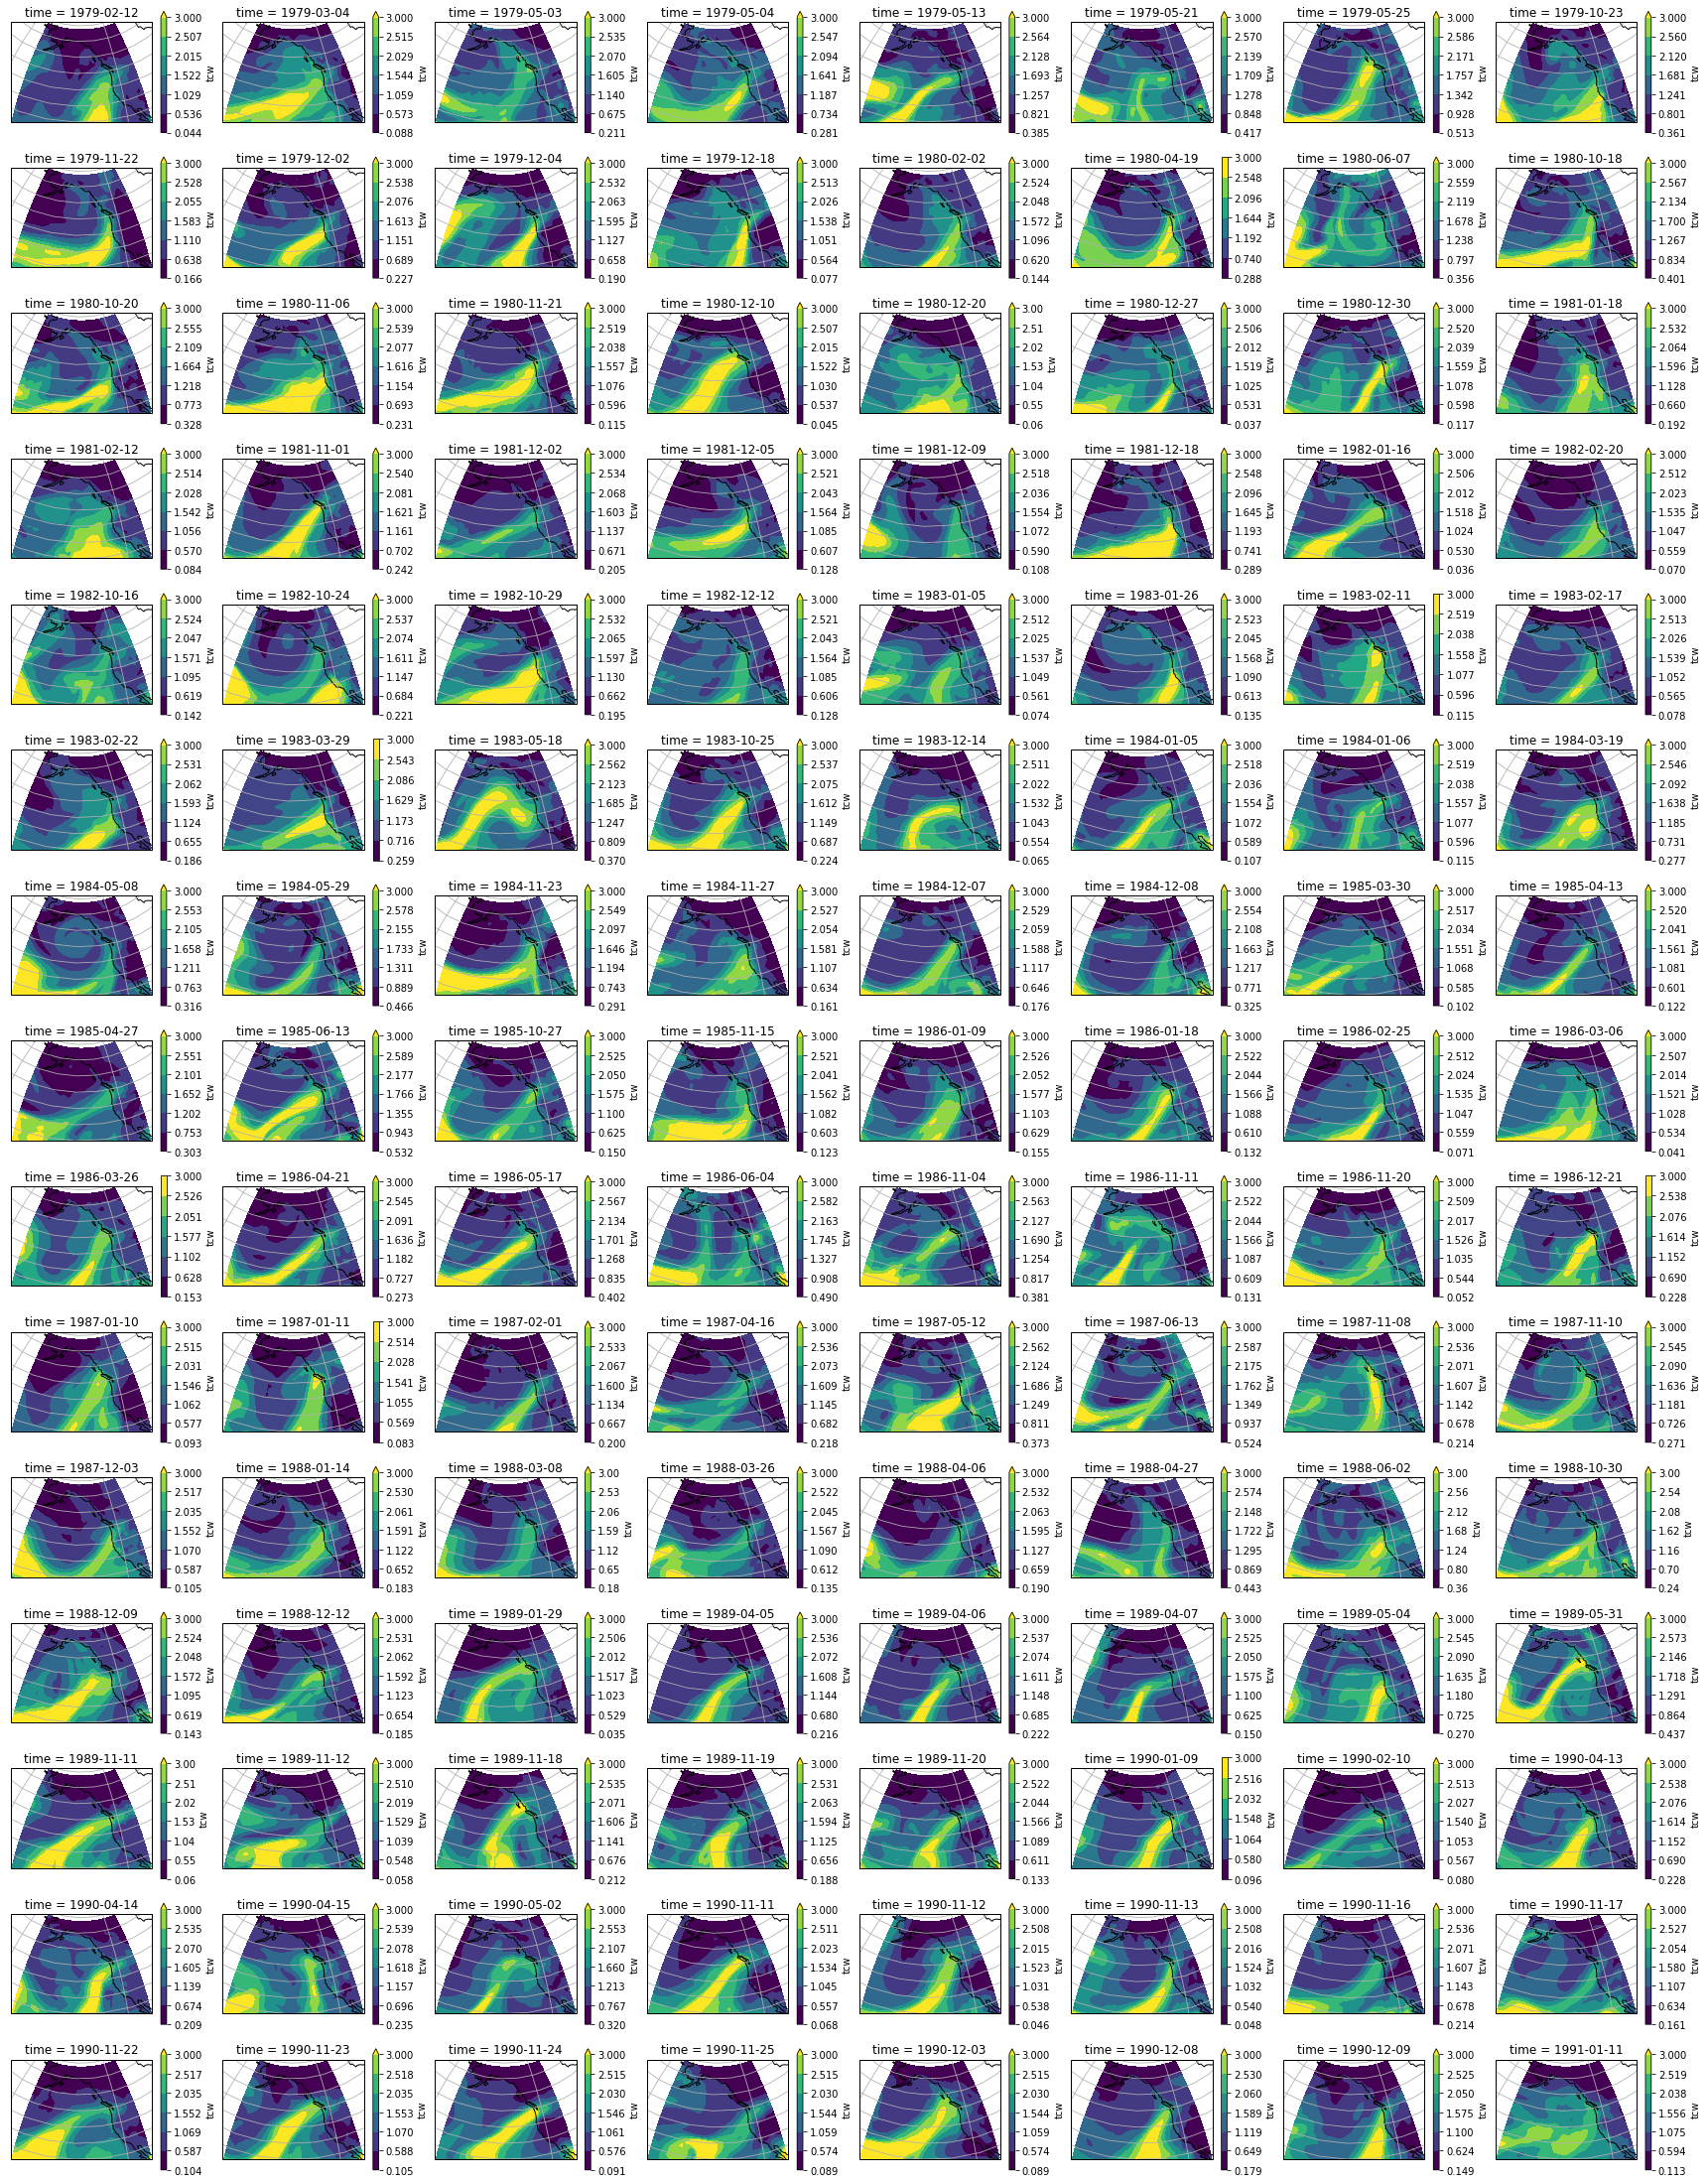

In [8]:
plt.figure(figsize=(30,40)) 
for i, oneTime in enumerate(ARs):
    if i < 120: #a sample - the first 120
        oneTMQ = tmq.sel(time=oneTime)
        ax = plt.subplot(15,8,i+1, projection=ccrs.Orthographic(-140, 45))
        plotAR(ax,oneTMQ,bounds)

## Read in some additional ERA-I output to plot AR-day composites:

In [9]:
#--------500 mbar heights-----------
directoryData = '/data/public/reanalysis/erai_daily_netcdf/geopotential/'
field = 'z'

oneFile = ''.join([directoryData,'ERAI_z_1979-2016.nc'])

bounds = GeographicBounds(190, 250, 20, 65)
myGeoP = xy.open_dataset(oneFile)
myGeoP = myGeoP.sel(longitude=slice(bounds.lonMin,bounds.lonMax),latitude=slice(bounds.latMax,bounds.latMin))

GeoP = myGeoP[field].sel(level=500)/9.8
GeoP = GeoP.resample(time='D').mean('time')

In [10]:
#--------2 meter air temperature--------
directoryData = '/data/public/reanalysis/erai_daily_netcdf/t2m/'
field = 't2m'

oneFile = ''.join([directoryData,'ERAI_t2m_1979-2016.nc'])

bounds = GeographicBounds(190, 250, 20, 65)
myTREFHT = xy.open_dataset(oneFile)
myTREFHT = myTREFHT[field].sel(longitude=slice(bounds.lonMin,bounds.lonMax),latitude=slice(bounds.latMax,bounds.latMin))
myTREFHT = myTREFHT.resample(time='D').mean('time')

In [11]:
climoTREFHT = myTREFHT.sel(time=slice('19821201','20120531')).groupby('time.month').mean('time') #doing this only once speeds things up

def subtractClimoOfMonth(y):
    return y - climoTREFHT.sel(month=np.int(y['time.month']))

In [12]:
def plotComposites(ax,noColorbar=True):
    ax.set_extent((bounds.lonMin, bounds.lonMax, bounds.latMin, bounds.latMax)) 

    CS = GeoP.sel(time=sampleDays).mean('time').plot.contour(ax=ax, levels=10, transform=ccrs.PlateCarree(),colors='g') #vmin=-5,vmax=5,cmap=cm.bwr
    plt.clabel(CS, inline=True, fmt='%.0f', fontsize=10)
    
    tmqCS = tmq.sel(time=sampleDays).mean('time').squeeze().plot.contour(ax=ax, levels=[2,2.5,3], transform=ccrs.PlateCarree(),colors='purple')
    plt.clabel(tmqCS, inline=True, fmt='%.0f',fontsize=10)
    
    toPlotTanom = myTREFHT.sel(time=sampleDays).groupby('time').apply(subtractClimoOfMonth).mean('time')
    temp = toPlotTanom.plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree(),vmin=-6,vmax=6,cmap=cm.RdBu_r)
    if noColorbar:
        cb = temp.colorbar
        cb.remove()
    
    ax.coastlines()
    ax.gridlines() 

In [13]:
onlyARdays = eventsOne[eventsOne[0]==1]
ARdaysDJF = onlyARdays.loc[(onlyARdays.index.month==startMonth('DJF'))]

Text(0.5,1,'2 days after')

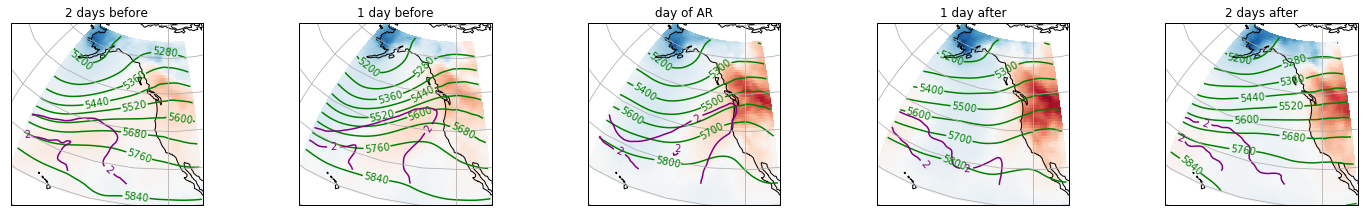

In [14]:
plt.figure(figsize=[25,5])
sampleDays = ARdaysDJF['19821201':'20120228'].index.shift(-2,'D')
ax = plt.subplot(1,5,1, projection=ccrs.Orthographic(-120, 35))
plotComposites(ax)
plt.title('2 days before')
sampleDays = ARdaysDJF['19821201':'20120228'].index.shift(-1,'D')
ax = plt.subplot(1,5,2, projection=ccrs.Orthographic(-120, 35))
plotComposites(ax)
plt.title('1 day before')
sampleDays = ARdaysDJF['19821201':'20120228'].index #'19821223'
ax = plt.subplot(1,5,3, projection=ccrs.Orthographic(-120, 35))
plotComposites(ax)
plt.title('day of AR')
sampleDays = ARdaysDJF['19821201':'20120228'].index.shift(1,'D')
ax = plt.subplot(1,5,4, projection=ccrs.Orthographic(-120, 35))
plotComposites(ax)
plt.title('1 day after')
sampleDays = ARdaysDJF['19821201':'20120228'].index.shift(2,'D')
ax = plt.subplot(1,5,5, projection=ccrs.Orthographic(-120, 35))
plotComposites(ax)
plt.title('2 days after')